In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor
import pytensor.tensor as pt
import scipy.stats as ss
from tqdm.notebook import tqdm

In [16]:
def marginal_loglike(theta, log_normal_wts, log_normal_w, log_other_wts, Sigma, mu, alpha, n_normal):
    L = pt.slinalg.cholesky(Sigma)

    r = theta[:,:n_normal] - mu
    rw = pt.slinalg.solve_triangular(L, r.T, lower=True).T

    logsqrtdet = pt.sum(pt.log(pt.diag(L)))

    logl_normal = -0.5*pt.sum(rw*rw, axis=1) - logsqrtdet
    logls = logl_normal + log_normal_wts - log_normal_w - (alpha+1)*pt.log(theta[:, n_normal:]) + pt.log(alpha) - log_other_wts

    return pt.logsumexp(logls)

def make_subset_normal_normal_model(thetas, prior_wts_normal, prior_wts_other, n_normal):
    nobs, nsamp, ndim = thetas.shape
    n_other = ndim - n_normal
    assert prior_wts_normal.shape == (nobs, nsamp), 'incorrect shape in prior_wts_normal'
    assert prior_wts_other.shape == (nobs, nsamp), 'incorrect shape in prior_wts_other'

    # Here we compute the full covariance matrices for the each of the sets of samples:
    wts = 1/prior_wts_normal
    w = np.sum(wts, axis=1)
    theta_mus = np.sum(wts[:,:,None]*thetas, axis=1) / w[:, None] # Shape is (nobs, ndim)
    theta_cov = np.sum(wts[:, :, None, None]*(thetas[:, :, :, None] - theta_mus[:, None, :, None])*(thetas[:, :, None, :] - theta_mus[:, None, None, :]), axis=1) / w[:, None, None] # shape (nobs, ndim, ndim)
    theta_cov_inv = np.linalg.inv(theta_cov) # (nobs, ndim, ndim)
    theta_cov_inv_normal = theta_cov_inv[:, :n_normal, :n_normal] # (nobs, n_normal, n_normal)
    theta_cov_normal = np.linalg.inv(theta_cov_inv_normal) # (nobs, n_normal, n_normal)

    log_normal_wts = np.log(wts) # (nobs, nsamp)
    log_normal_w = np.log(w) # (nobs,)
    log_other_wts = np.log(prior_wts_other) # (nobs, n_other)

    neff = np.square(np.sum(wts, axis=1)) / np.sum(np.square(wts), axis=1)
    kde_bw = theta_cov_normal / neff[:,None,None]**(2 / (4 + n_normal)) # Scott's rule

    # Turn stuff into tensor variables
    thetas = pt.as_tensor(thetas)
    log_normal_wts = pt.as_tensor(log_normal_wts)
    log_normal_w = pt.as_tensor(log_normal_w)
    log_other_wts = pt.as_tensor(log_other_wts)

    with pm.Model() as model:
        # Here we create population parameters for the dimensions that have a
        # normal population model.  mu is the population mean (vector).  Sigma
        # is the population covariance matrix; if you want to only have a
        # diagonal covariance matrix, you can replace the last two lines with
        # Sigma = pt.diag(pt.square(pm.HalfNormal('sigmas', 1, shape=n_normal)))
        # which creates a diagonal covariance matrix with unit half-normal
        # distributions for the standard deviations.  
        #
        # You can read more about the LKJ prior for covariance matrices at
        # https://en.wikipedia.org/wiki/Lewandowski-Kurowicka-Joe_distribution .
        # The idea is to specify a distribution for the standard deviations /
        # scales of each dimension (here a unit HalfNormal), and then impose a
        # distribution on the correlation matrix that is isotropic and has a
        # single parameter 'eta' (here set to 2) that regulates how much you
        # prefer a diagonal correlation (i.e. zero cross-correlation between the
        # dimensions) versus off-diagonal.  `eta = 1` is a flat prior on the
        # coefficients of the correlation matrix, and eta = 2 is a mild
        # preference for diagonal correlations.  `eta -> infinity` will take you
        # back to the diagonal covariance discussed above.
        mu = pm.Normal('mu', 0, 1, shape=n_normal)
        Sigma_chol, Sigma_corr, Sigma_sqrt_diag = pm.LKJCholeskyCov('Sigma_chol', 2, n_normal, pm.HalfNormal.dist(1))
        Sigma = pm.Deterministic('Sigma', pt.dot(Sigma_chol, Sigma_chol.T))
        _ = pm.Deterministic('sqrt_Sigma_diag', pt.sqrt(pt.diag(Sigma)))

        # Fill in other parameter distributions here, for the non-normal parts
        # of the sample.  I'm going to pretend to fit a power-law index to one
        # other dimension just to illustrate how things work.
        alpha = pm.Uniform('alpha', 0, 4, shape=n_other)

        # Here we integrate over the true parameter in the product of KDE
        # likelihood and normal popluation.  This produces one marginal
        # covariance for each observation, which is the sum of the population's
        # covariance and the KDE bandwidth
        Sigma_marginal = Sigma[None, :, :] + kde_bw[:, :, :] # shape = (nobs, n_normal, n_normal)

        _ = pm.Potential('log_marginal_like', pt.sum(pytensor.scan(marginal_loglike,
                                                                   sequences=[thetas, log_normal_wts, log_normal_w, log_other_wts, Sigma_marginal],
                                                                   non_sequences=[mu, alpha, n_normal],
                                                                   strict=True)[0]))

    return model

In [17]:
nobs = 128
nsamp = 128
nnormal = 3
ndim = 4

alpha_true = 2

# Our true population is zero-mean, delta function in the first dimension, small-ish variation in the other two
mu_true = np.zeros(nnormal)
cov_true = np.diag([0, 0.01, 0.01])

true_params = np.concatenate((np.zeros(nobs)[:, None], np.random.multivariate_normal(mu_true[1:], cov_true[1:,1:], size=nobs), np.random.pareto(alpha_true, size=nobs)[:,None]+1), axis=1)

In [18]:
samples = []
for i in range(nobs):
    p = true_params[i,:]

    # A random covariance matirx with more-or-less unit scale, but crazy correlations.
    Sigma = np.random.normal(size=(ndim,ndim))
    Sigma = np.dot(Sigma, Sigma.T)

    p_obs = p + np.random.multivariate_normal(np.zeros(ndim), Sigma)

    # Because the observation is just the true parameters with additive Gaussian
    # noise, the likelihood function is Gaussian as well, with the same Sigma,
    # centered at the observed values.  There is a prior constraint that the
    # pareto parameter cannot be less than one, so we re-sample until all our
    # draws satisfy that constraint.
    p_samples = np.random.multivariate_normal(p_obs, Sigma, size=nsamp)
    while np.any(p_samples[:, -1] < 1):
        s = p_samples[:,-1] < 1
        p_samples[s, :] = np.random.multivariate_normal(p_obs, Sigma, size=np.sum(s))
    
    samples.append(p_samples)
samples = np.array(samples)

# We used a flat prior, so the weights are just a constant.
wts_normal = np.ones((nobs, nsamp))
wts_other = np.ones((nobs, nsamp))

In [19]:
model = make_subset_normal_normal_model(samples, wts_normal, wts_other, nnormal)

In [20]:
nmcmc = 100
nchain = 4
with tqdm(total=2*nchain*nmcmc, smoothing=10/(2*nchain*nmcmc)) as bar:
    with model:
        trace = pm.sample(draws=nmcmc, tune=nmcmc, chains=nchain, callback=lambda **kwargs: bar.update(1), progressbar=False)

  0%|          | 0/800 [00:00<?, ?it/s]

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, Sigma_chol, alpha]
Sampling 4 chains for 100 tune and 100 draw iterations (400 + 400 draws total) took 708 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


array([[<Axes: title={'center': 'mu'}>, <Axes: title={'center': 'mu'}>],
       [<Axes: title={'center': 'sqrt_Sigma_diag'}>,
        <Axes: title={'center': 'sqrt_Sigma_diag'}>],
       [<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>]], dtype=object)

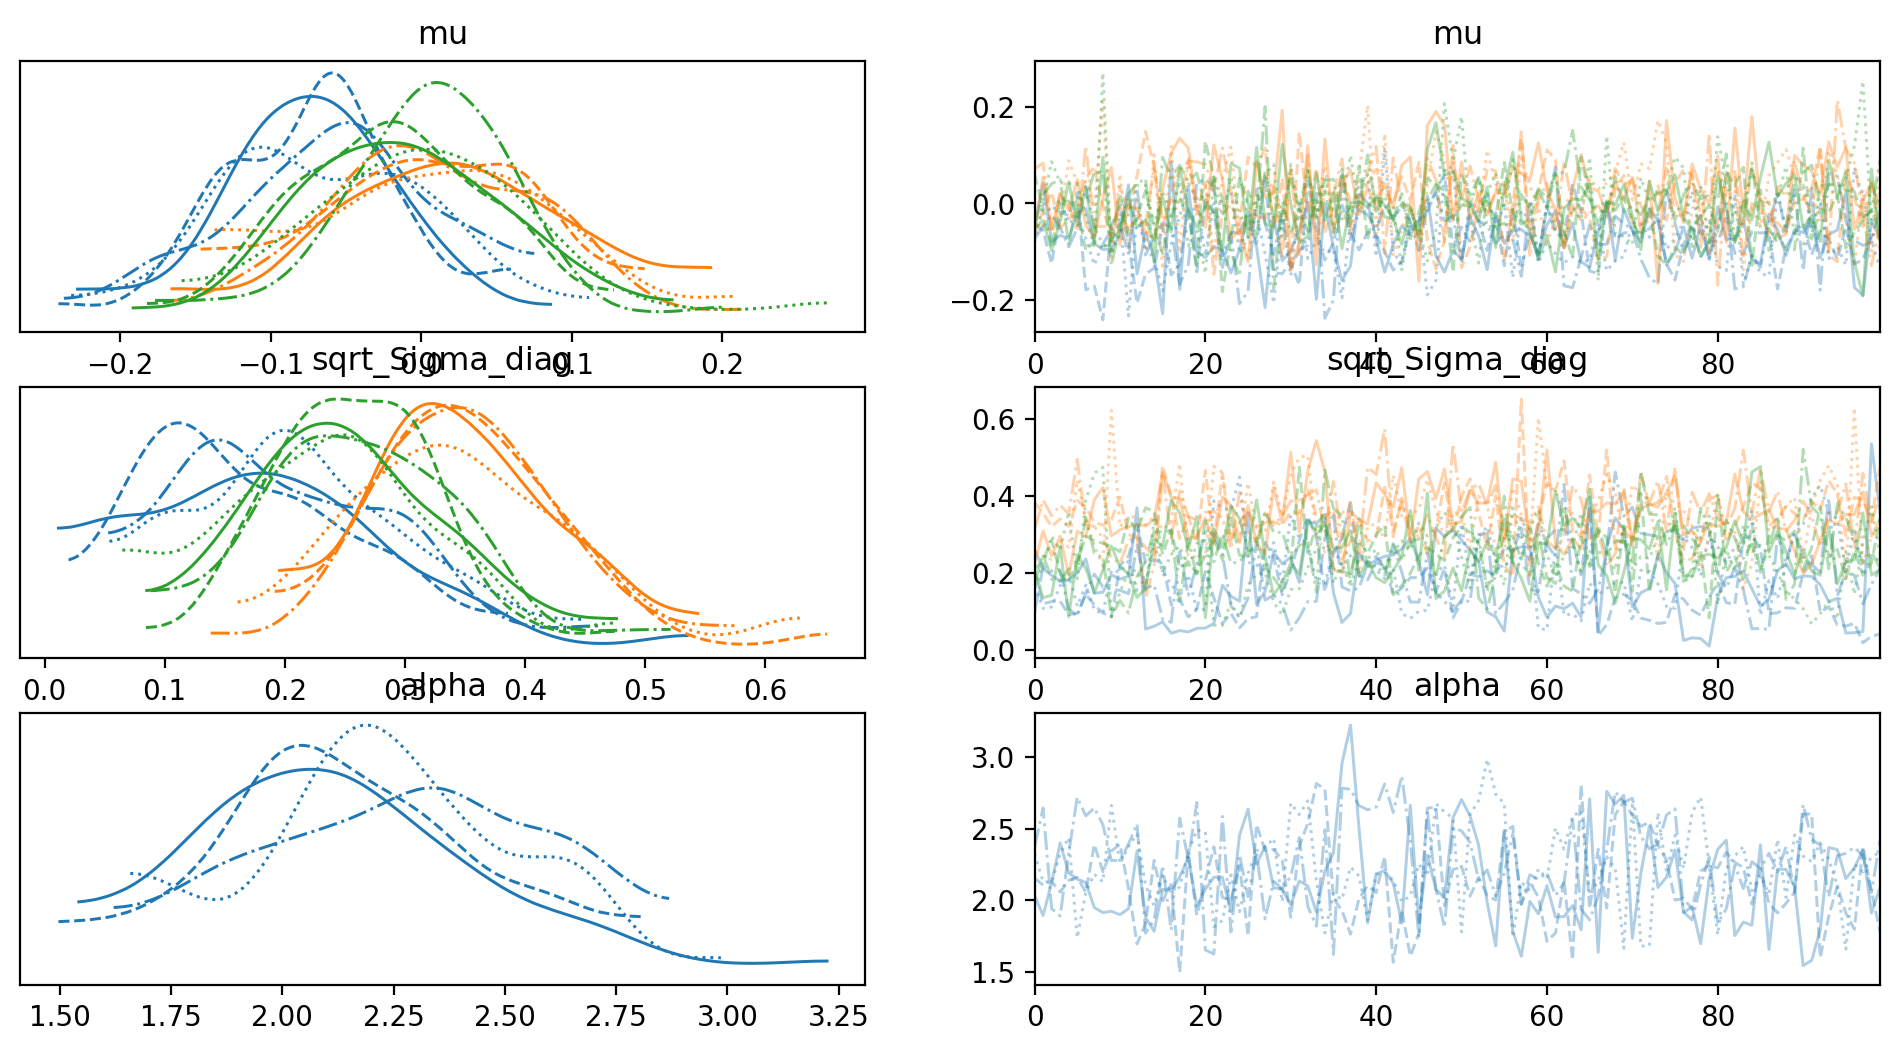

In [21]:
az.plot_trace(trace, var_names=['mu', 'sqrt_Sigma_diag', 'alpha'])